# Optimized PyTorch CNN with Optuna

In this notebook, we optimize a convolutional neural network (CNN) for the CIFAR-10 dataset using Optuna for hyperparameter tuning.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import make_data_loaders
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.hyperparameter_optimization import create_cnn, create_objective
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves, plot_optimization_results
)
from image_classification_tools.pytorch.training import train_model

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Fixed hyperparameters

In [2]:
# Optuna settings
run_optimization = False # Run optimization (True) or load results from disk for evaluation (False)
start_new_study = False  # Clear results and start new study (True) or resume previous run (False) 
n_trials = 200           # Number of optimization trials
n_epochs_per_trial = 100 # Epochs per trial
n_epochs_final = 150     # Epochs for final model training with optimized hyperparameters
print_every = 10         # Print training progress every n epochs

# SQLite storage for Optuna (local file)
data_dir = Path('../data/pytorch')
data_dir.mkdir(parents=True, exist_ok=True)
storage_path = data_dir / 'cnn_optimization.db'
storage_url = f'sqlite:///{storage_path}'

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Visualize CIFAR-10 sample images

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes.

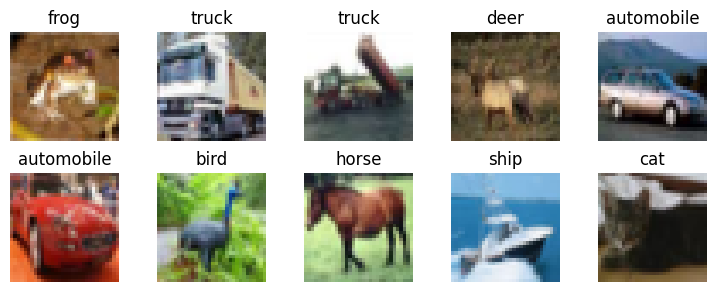

In [3]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Define transform (RGB)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Get a sample dataset for visualization
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

## 2. Optuna hyperparameter optimization

We use `create_objective()` to generate an objective function that Optuna will optimize.
The function samples hyperparameters, creates and trains a model, and returns validation accuracy.

### 2.1. Define hyperparameter search space

In [4]:
# Define hyperparameter search space
search_space = {
    'batch_size': [64, 128, 256, 512, 1024],
    'n_conv_blocks': (1, 5),  # (min, max) for int range
    'initial_filters': [8, 16, 32, 64, 128],
    'n_fc_layers': (1, 8),
    'base_kernel_size': (3, 7),
    'conv_dropout_rate': (0.0, 0.5),  # (min, max) for float range
    'fc_dropout_rate': (0.2, 0.75),
    'pooling_strategy': ['max', 'avg'],
    'use_batch_norm': [True, False],
    'learning_rate': (1e-5, 1e-1, 'log'),  # (min, max, scale)
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'sgd_momentum': (0.8, 0.99)  # Used when optimizer='SGD'
}

print('Hyperparameter search space:')

for key, value in search_space.items():
    print(f'  {key}: {value}')

Hyperparameter search space:
  batch_size: [64, 128, 256, 512, 1024]
  n_conv_blocks: (1, 5)
  initial_filters: [8, 16, 32, 64, 128]
  n_fc_layers: (1, 8)
  base_kernel_size: (3, 7)
  conv_dropout_rate: (0.0, 0.5)
  fc_dropout_rate: (0.2, 0.75)
  pooling_strategy: ['max', 'avg']
  use_batch_norm: [True, False]
  learning_rate: (1e-05, 0.1, 'log')
  optimizer: ['Adam', 'SGD', 'RMSprop']
  sgd_momentum: (0.8, 0.99)


### 2.3. Run optimization

### 2.2. Create objective function

In [5]:
# Create objective function for Optuna
objective = create_objective(
    data_dir=data_dir,
    train_transform=transform,
    eval_transform=transform,
    n_epochs=n_epochs_per_trial,
    device=device,
    num_classes=num_classes,
    search_space=search_space
)

In [6]:
%%time

if run_optimization:
    print('Running hyperparameter optimization...')

    # Delete existing study if desired & it exists
    if start_new_study == True:
        try:
            optuna.delete_study(study_name='cnn_optimization', storage=storage_url)
            print('Deleted existing study')

        except KeyError:
            print('No existing study found')

    # Create Optuna study with SQLite storage (maximize validation accuracy)
    study = optuna.create_study(
        direction='maximize',
        study_name='cnn_optimization',
        storage=storage_url,
        load_if_exists=True,  # Resume if study already exists
        pruner=None #optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    print(f'Study stored at: {storage_path}')

    # Run optimization
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

else:

    # Load results from disk
    study = optuna.load_study(
        study_name='cnn_optimization',
        storage=storage_url
    )

    print(f'Study loaded from: {storage_path}')

print(f'\nBest validation accuracy: {study.best_trial.value:.2f}%')

for key, value in study.best_trial.params.items():
    print(f' - {key}: {value}')

print()

Study loaded from: ../data/pytorch/cnn_optimization.db

Best validation accuracy: 84.86%
 - batch_size: 512
 - n_conv_blocks: 2
 - initial_filters: 128
 - n_fc_layers: 4
 - base_kernel_size: 3
 - conv_dropout_rate: 0.35056278489395826
 - fc_dropout_rate: 0.38114032026131617
 - pooling_strategy: avg
 - use_batch_norm: True
 - learning_rate: 0.020180175220883435
 - optimizer: SGD
 - sgd_momentum: 0.8791693471355531

CPU times: user 605 ms, sys: 38 ms, total: 643 ms
Wall time: 642 ms


### 2.4. Visualize optimization results

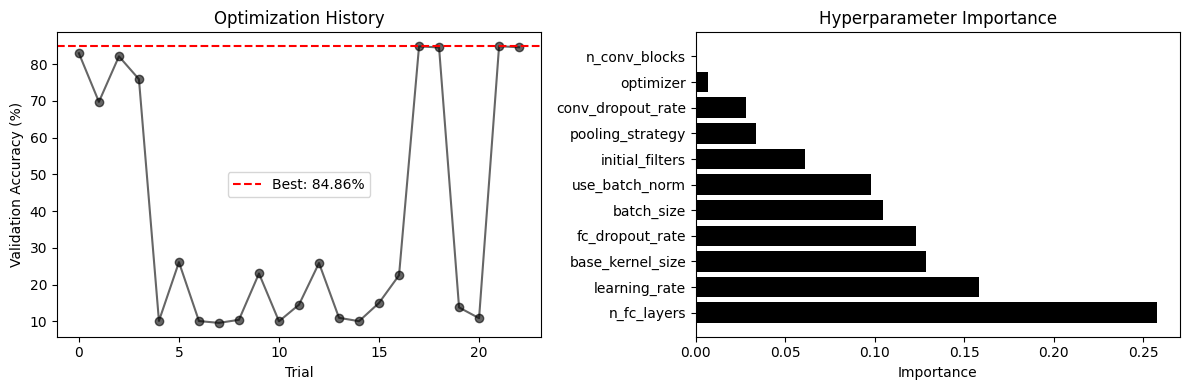

In [7]:
fig, axes = plot_optimization_results(study)
plt.show()

## 3. Train final model with best hyperparameters

### 3.1. Create optimized model

In [ ]:
# Extract best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
for key, value in best_params.items():
    print(f'  {key}: {value}')

# Recreate data loaders with best batch size
best_batch_size = best_params['batch_size']

train_loader, val_loader, test_loader = make_data_loaders(
    data_dir=data_dir,
    batch_size=best_batch_size,
    train_transform=transform,
    eval_transform=transform,
    device=device
)

print(f'\nRecreated data loaders with batch size: {best_batch_size}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    base_kernel_size=best_params['base_kernel_size'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    pooling_strategy=best_params['pooling_strategy'],
    use_batch_norm=best_params['use_batch_norm']
).to(device)

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

elif best_params['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9)
    )

else:  # RMSprop
    best_optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

# Set cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# Get total trainable parameters
trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)

print(f'\n{best_model}')
print(f'\nTotal parameters: {trainable_params:,}')

Best hyperparameters:
  batch_size: 512
  n_conv_blocks: 2
  initial_filters: 128
  n_fc_layers: 4
  base_kernel_size: 3
  conv_dropout_rate: 0.35056278489395826
  fc_dropout_rate: 0.38114032026131617
  pooling_strategy: avg
  use_batch_norm: True
  learning_rate: 0.020180175220883435
  optimizer: SGD
  sgd_momentum: 0.8791693471355531

Recreated data loaders with batch size: 512
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Dropout(p=0.35056278489395826, inplace=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

### 3.2. Train optimized model

In [ ]:
%%time

history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    epochs=n_epochs_final,
    print_every=print_every
)

print()

Epoch 1/150 - loss: 2.1882 - accuracy: 17.07% - val_loss: 1.9623 - val_accuracy: 28.00%
Epoch 10/150 - loss: 0.6328 - accuracy: 77.68% - val_loss: 0.7460 - val_accuracy: 74.56%
Epoch 20/150 - loss: 0.2313 - accuracy: 91.83% - val_loss: 0.6093 - val_accuracy: 81.26%
Epoch 30/150 - loss: 0.0764 - accuracy: 97.43% - val_loss: 0.7612 - val_accuracy: 82.60%
Epoch 40/150 - loss: 0.0362 - accuracy: 98.89% - val_loss: 0.7554 - val_accuracy: 83.83%
Epoch 50/150 - loss: 0.0309 - accuracy: 98.98% - val_loss: 0.8666 - val_accuracy: 83.47%
Epoch 60/150 - loss: 0.0119 - accuracy: 99.61% - val_loss: 0.9123 - val_accuracy: 83.61%
Epoch 70/150 - loss: 0.0116 - accuracy: 99.64% - val_loss: 0.8375 - val_accuracy: 84.60%
Epoch 80/150 - loss: 0.0106 - accuracy: 99.66% - val_loss: 0.8579 - val_accuracy: 84.47%
Epoch 90/150 - loss: 0.0113 - accuracy: 99.67% - val_loss: 0.9090 - val_accuracy: 84.22%
Epoch 100/150 - loss: 0.0055 - accuracy: 99.81% - val_loss: 0.8718 - val_accuracy: 84.89%
Epoch 110/150 - loss:

### 3.3. Learning curves

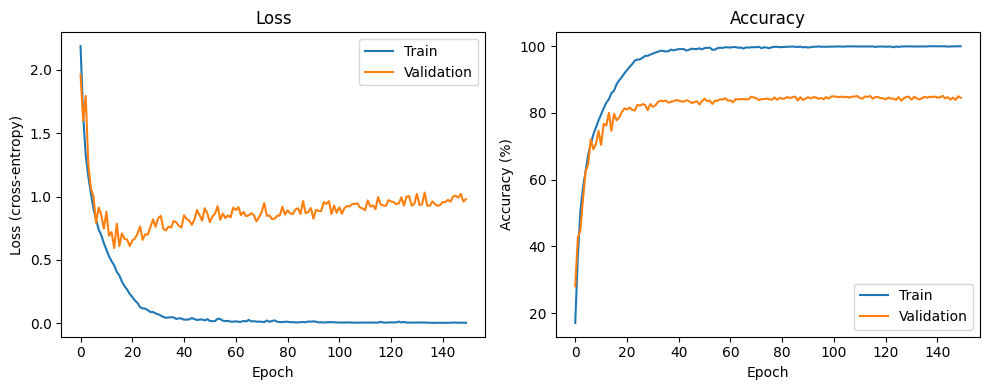

In [10]:
fig, axes = plot_learning_curves(history)
plt.show()

## 4. Evaluate optimized model on test set

### 4.1. Calculate test accuracy

In [11]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 84.33%


### 4.2. Per-class accuracy

In [12]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 84.00%
automobile  : 92.40%
bird        : 73.00%
cat         : 70.70%
deer        : 83.60%
dog         : 78.60%
frog        : 90.30%
horse       : 86.00%
ship        : 93.20%
truck       : 91.50%


### 4.3. Confusion matrix

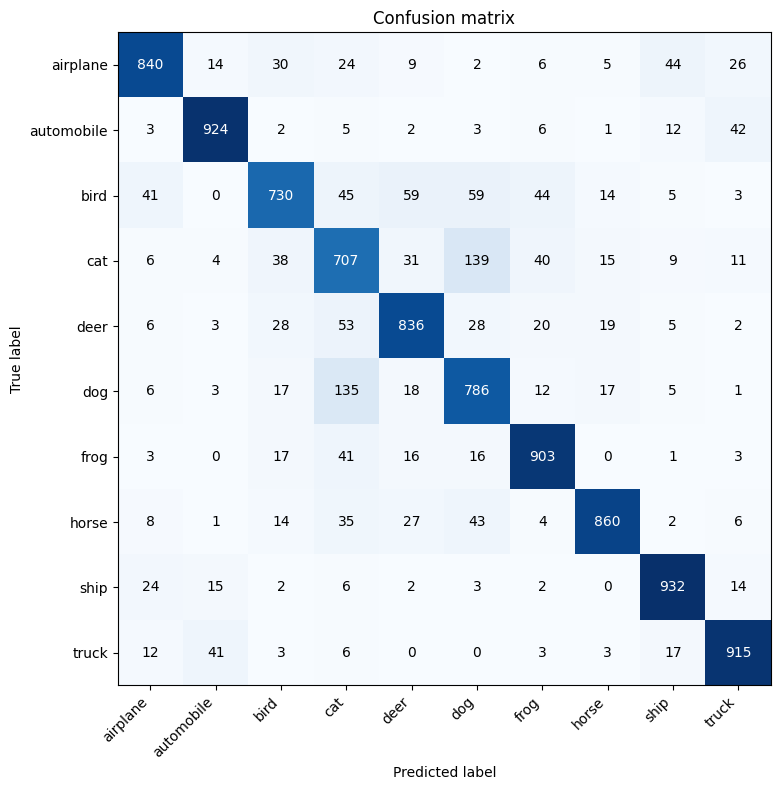

In [13]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 4.4. Predicted class probability distributions

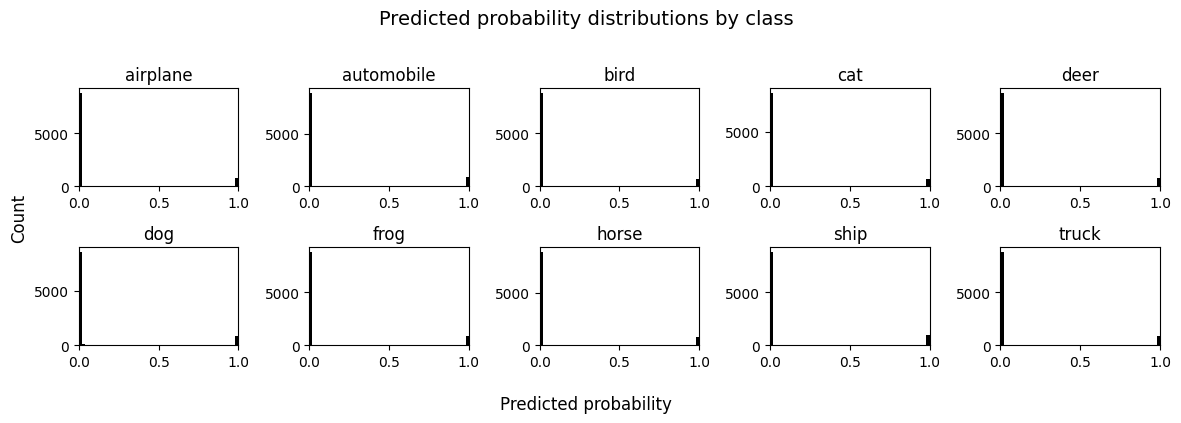

In [14]:
# Get predicted probabilities for all test samples
best_model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 4.5. Evaluation curves

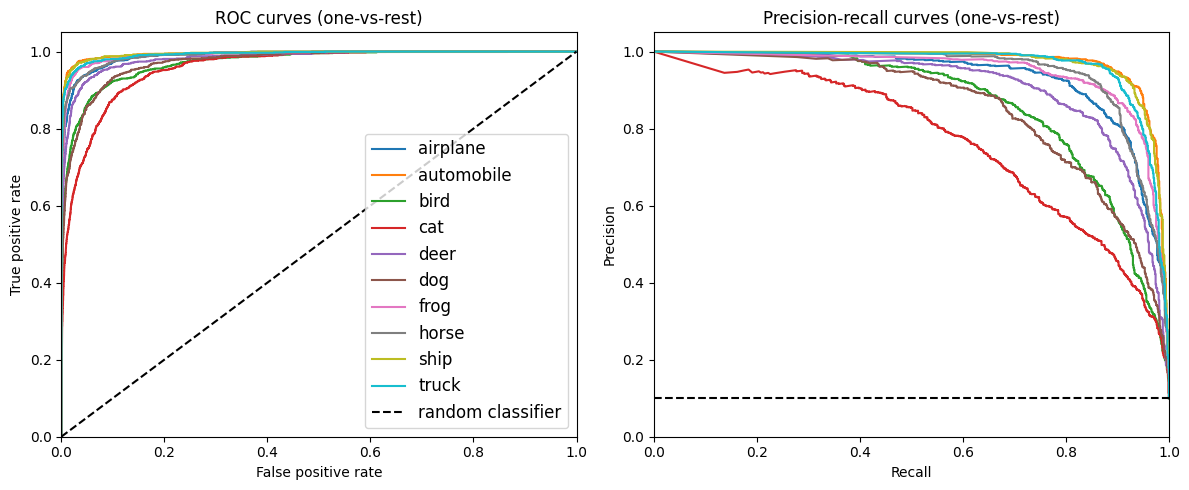

In [15]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 5. Save optimized model and hyperparameters

In [16]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'optimized_cnn.pth'

torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': best_optimizer.state_dict(),
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/optimized_cnn.pth
Test accuracy: 84.33%
